# Importing Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Pipelining and Preprocessing

Note: Train with other type of data also

In [1]:
from tensorflow.keras.preprocessing import image

import numpy as np
import tensorflow as tf

from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import os
import time

from matplotlib import pyplot as plt
from IPython import display
from tqdm import tqdm

Using Dataset_2 as the main training data for results

In [2]:
PATH = '/content/drive/My Drive/COVID-19_Project/Classification_of_Medical_Images/Final_Dataset_Augmented_and_mirror_all_new/'

In [3]:
IMG_WIDTH = 299
IMG_HEIGHT = 299

In [4]:
data_dir_list = os.listdir(PATH)
data_dir_list

['Covid-19', 'Normal', 'Pneumonia']

In [5]:
img_data_list = []
image_path_list = []

In [6]:
for dataset in data_dir_list:
    img_list = os.listdir(PATH+dataset+'/')
    print('Loading the images of dataset - '+ '{}\n'.format(dataset))
    count = 0
    for img in tqdm(img_list):
        img_path = PATH+dataset+'/'+img
        image_path_list.append(img_path)
        img = image.load_img(img_path, target_size=(IMG_WIDTH,IMG_HEIGHT))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        img_data_list.append(x)
        count = count+1
        if count == 800:
          # otherwise make 700-700 divisions
          break

  3%|▎         | 28/1000 [00:00<00:03, 279.80it/s]

Loading the images of dataset - Covid-19



  3%|▎         | 31/1000 [00:00<00:03, 308.80it/s]

Loading the images of dataset - Normal



  3%|▎         | 32/1000 [00:00<00:03, 313.97it/s]

Loading the images of dataset - Pneumonia



 77%|███████▋  | 773/1000 [00:02<00:00, 291.80it/s]


In [7]:
img_data = np.array(img_data_list)
img_data = np.rollaxis(img_data,1,0)
img_data = img_data[0]
img_data = img_data.astype('int32')
img_data = np.abs(img_data)
print(img_data.shape)

(2400, 299, 299, 3)


In [8]:
len(image_path_list)

2400

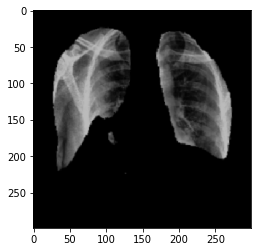

In [9]:
plt.imshow(img_data[500])

In [10]:
img_data.dtype

dtype('int32')

# Neural Network Training

Note: use other networks also

## Data Preprocessing 

In [11]:
num_classes = 3
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples), dtype = 'int32')

In [12]:
labels[:500] = 0
labels[500:1000] = 1
labels[1000:] = 2

names = ['Covid-19', 'Normal', 'Pneumonia']

In [13]:
labels.shape

(1500,)

In [14]:
Y = np_utils.to_categorical(labels, num_classes)

x,y = shuffle(img_data,Y, random_state=2)

#X_model, X_test,Y_model, Y_test = train_test_split(x, y, test_size = 0.1, random_state = 2)

X_train_NN, X_test_NN, y_train_NN, y_test_NN = train_test_split(x, y, test_size = 0.2, random_state = 2)

In [15]:
X_test_NN.shape

(300, 299, 299, 3)

In [16]:
X_train_NN.shape

(1200, 299, 299, 3)

In [17]:
y_train_NN.shape

(1200, 3)

## Training

90

In [18]:
import tensorflow as tf
# shape 299, 299, 3

In [22]:
Xception = tf.keras.applications.Xception(
    include_top=True, weights='imagenet', input_tensor=None, input_shape=None,
    pooling=None, classes=1000
)

91889664/91884032 [==============================] - 9s 0us/step


In [23]:
Xception.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [24]:
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.models import Model
last_layer = Xception.get_layer('avg_pool').output
x = Dense(1024, activation='relu', name='fc1')(last_layer)
x = Dense(512, activation='relu', name='fc2')(x)
x = Dense(256, activation='relu', name='fc3')(x)
out = Dense(num_classes, activation = 'softmax', name = 'output')(x)
custom_model = Model(Xception.input, out)

In [25]:
for layer in custom_model.layers[:-4]:
    layer.trainable = False

In [26]:
opt = tf.keras.optimizers.Adam(
    learning_rate=0.001
)

In [27]:
custom_model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

In [28]:
custom_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [19]:
from tensorflow.keras.applications.xception import preprocess_input
X_train_pp = preprocess_input(X_train_NN)
X_test_pp = preprocess_input(X_test_NN)
#X_test = preprocess_input(X_test)

In [30]:
callbacks = [
    #tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
    #tf.keras.callbacks.TensorBoard(log_dir='logs\{}'.format(NAME)),
    tf.keras.callbacks.ModelCheckpoint('Xception.h5', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau()]

In [31]:
custom_model.fit(X_train_pp, y_train_NN, batch_size=32, epochs=100, verbose=1, validation_data = (X_test_pp, y_test_NN), callbacks = callbacks)

Epoch 1/100
53/53 [==============================] - 20s 369ms/step - loss: 0.4605 - accuracy: 0.8185 - val_loss: 0.2549 - val_accuracy: 0.9024
Epoch 2/100
53/53 [==============================] - 18s 333ms/step - loss: 0.2281 - accuracy: 0.9113 - val_loss: 0.3911 - val_accuracy: 0.8571
Epoch 3/100
53/53 [==============================] - 18s 345ms/step - loss: 0.1805 - accuracy: 0.9321 - val_loss: 0.1615 - val_accuracy: 0.9452
Epoch 4/100
53/53 [==============================] - 18s 347ms/step - loss: 0.1609 - accuracy: 0.9357 - val_loss: 0.1249 - val_accuracy: 0.9500
Epoch 5/100
53/53 [==============================] - 18s 342ms/step - loss: 0.1063 - accuracy: 0.9649 - val_loss: 0.2182 - val_accuracy: 0.9190
Epoch 6/100
53/53 [==============================] - 18s 344ms/step - loss: 0.1047 - accuracy: 0.9595 - val_loss: 0.2834 - val_accuracy: 0.8619
Epoch 7/100
53/53 [==============================] - 18s 348ms/step - loss: 0.1301 - accuracy: 0.9565 - val_loss: 0.1653 - val_accuracy:

In [32]:
classifier = tf.keras.models.load_model("Xception.h5")

In [33]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = classifier.predict(X_test_pp)
y_p = np.argmax(y_pred,axis=1)
y_true = np.argmax(y_test_NN,axis=1)
print('confusion matrix')
print(confusion_matrix(y_true,y_p))

confusion matrix
[[142   0   0]
 [  2 150   3]
 [  3   9 111]]


In [34]:
print('Classification report')
print(classification_report(y_true,y_p))

Classification report
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       142
           1       0.94      0.97      0.96       155
           2       0.97      0.90      0.94       123

    accuracy                           0.96       420
   macro avg       0.96      0.96      0.96       420
weighted avg       0.96      0.96      0.96       420



###Testing the model with ML techniques

In [19]:
classifier = tf.keras.models.load_model("Xception.h5")

In [20]:
from tensorflow.keras.models import Model

op_layer = classifier.get_layer('fc3').output
Model_new = Model(inputs = classifier.input , outputs = op_layer)

In [21]:
Model_new.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [22]:
x_new,y_new = shuffle(img_data,labels, random_state=2)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(x_new, y_new, test_size = 0.1, random_state = 2)

In [23]:
from tensorflow.keras.applications.xception import preprocess_input
X_train_1 = preprocess_input(X_train_1)
X_test_1 = preprocess_input(X_test_1)

In [24]:
y_train_1.shape

(1350,)

In [25]:
train_new = Model_new.predict(X_train_1)
test_new = Model_new.predict(X_test_1)
print(test_new)

[[0.         0.         2.3159118  ... 1.8501216  0.2308807  1.3996733 ]
 [1.123625   0.         0.         ... 0.         0.         0.        ]
 [0.         0.         2.0108795  ... 0.19736913 0.08127717 1.3316287 ]
 ...
 [0.         0.         1.9197166  ... 1.7721118  0.0984029  1.0459381 ]
 [1.7539632  0.         0.         ... 0.         0.         0.        ]
 [0.99895906 0.         0.         ... 0.         0.         0.        ]]


In [26]:
test_new.shape

(150, 256)

#### svm

94 and 90

In [27]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', max_iter = 50000)

svm.fit(train_new,y_train_1)
print('fitting done !!!')
svm.score(train_new,y_train_1)

fitting done !!!


0.9896296296296296

fc3

In [28]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = svm.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[53  0  0]
 [ 0 50  0]
 [ 0  1 46]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       0.98      1.00      0.99        50
           2       1.00      0.98      0.99        47

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



#### xg_boost

92 and 91

In [29]:
import xgboost as xgb

xb = xgb.XGBClassifier(max_iter = 50000)

xb.fit(train_new,y_train_1)

print('fitting done !!!')

xb.score(train_new,y_train_1)

fitting done !!!


1.0

fc3

In [30]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = xb.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[53  0  0]
 [ 0 50  0]
 [ 0  1 46]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       0.98      1.00      0.99        50
           2       1.00      0.98      0.99        47

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



#### random forest

93 and 90

In [31]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=2000)
rf.fit(train_new,y_train_1)

print('fitting done !!!')

rf.score(train_new,y_train_1)

fitting done !!!


1.0

fc3

In [32]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = rf.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[53  0  0]
 [ 0 50  0]
 [ 0  1 46]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       0.98      1.00      0.99        50
           2       1.00      0.98      0.99        47

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



# Descriptors Extraction and Training

## Preprocessing the Data

In [11]:
! pip install opencv-python==3.4.2.16
! pip install opencv-contrib-python==3.4.2.16

     |████████████████████████████████| 25.0MB 137kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 109kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


Using: SIFT

In [12]:
import cv2

In [13]:
sift = cv2.xfeatures2d.SIFT_create()
des_list = []

In [14]:
for i in tqdm(range(len(img_data))):
  img = img_data[i].copy()
  img = np.uint8(img)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  kpts, des = sift.detectAndCompute(img, None)
  des_list.append((i, des))

100%|██████████| 2400/2400 [01:17<00:00, 30.80it/s]


In [15]:
image = cv2.drawKeypoints(image=img, outImage=img, keypoints=kpts, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

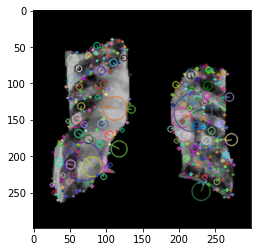

In [16]:
plt.imshow(image)
plt.show()

Using BRISK

In [11]:
import cv2

In [12]:
brisk = cv2.BRISK_create(50)
des_list = []

In [13]:
for i in tqdm(range(len(img_data))):
  img = img_data[i].copy()
  img = np.uint8(img)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  kpts, des = brisk.detectAndCompute(img, None)
  des_list.append((i, des))

100%|██████████| 2400/2400 [00:13<00:00, 171.47it/s]


In [14]:
image = cv2.drawKeypoints(image=img, outImage=img, keypoints=kpts, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

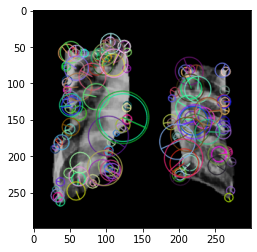

In [15]:
plt.imshow(image)
plt.show()

stacking all the descriptors vertically in a numpy array

In [16]:
descriptors = des_list[0][1]
for img_no, descriptor in tqdm(des_list[:]):
  try:
    descriptors = np.vstack((descriptors, descriptor))
  except:
    continue

100%|██████████| 2400/2400 [00:04<00:00, 530.25it/s]


In [17]:
descriptors_float = descriptors.astype(float)

Clustring using k means

Note: use others methods also

In [18]:
from scipy.cluster.vq import kmeans, vq
# we can change the value of k (no of clusters) to see the different accuracies
k = 128
voc, variance = kmeans(descriptors_float, k, 1)

calculating the histogram of the features and representing them as vectors.

vq(vector quantization) Assigns codes from a code book to observations.

In [19]:
im_features = np.zeros((len(img_data), k), "float32")
for i in tqdm(range(len(img_data))):
  try:
    words, distance = vq(des_list[i][1],voc)
    for w in words:
      im_features[i][w] += 1
  except:
    continue 

100%|██████████| 2400/2400 [00:02<00:00, 1096.46it/s]


performing Tf-Idf vectorization

In [20]:
nbr_occurances = np.sum((im_features > 0) * 1, axis = 0)
idf = np.array(np.log((1.0*len(img_data) + 1) / (1.0*nbr_occurances + 1)), "float32")

Scaling the words

Standardize features by removing the mean and scaling to unit variance

In a way normalizarion

In [21]:
from sklearn.preprocessing import StandardScaler
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)

In [22]:
im_features.shape

(2400, 128)

In [23]:
im_features.dtype

dtype('float32')

In [24]:
im_features

array([[-0.75922364,  0.5404384 , -0.33049577, ..., -0.26550367,
         0.5959698 ,  0.6436344 ],
       [ 0.04312631,  0.5404384 ,  2.4962678 , ...,  1.8886845 ,
         1.9745986 ,  0.6436344 ],
       [-0.75922364,  3.4469984 , -0.33049577, ...,  1.0270092 ,
         1.9745986 ,  2.1043646 ],
       ...,
       [-0.75922364,  0.5404384 , -0.33049577, ..., -0.26550367,
         2.6639132 , -0.08673087],
       [ 0.04312631,  0.5404384 , -0.33049577, ..., -0.26550367,
        -0.09334467, -0.81709605],
       [-0.75922364, -0.91284144,  0.23485695, ..., -0.26550367,
         0.5959698 , -0.81709605]], dtype=float32)

## Train and Test spliting 

In [25]:
num_classes = 3
num_of_samples = im_features.shape[0]
labels = np.ones((num_of_samples), dtype = 'int32')

labels[:800] = 0
labels[800:1600] = 1
labels[1600:] = 2

names = ['Covid-19', 'Normal', 'Pneumonia']

In [26]:
x,y = shuffle(im_features,labels, random_state=2)

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(x, y, test_size = 0.15, random_state = 2)

In [27]:
X_train_d.shape

(2040, 128)

In [28]:
y_train_d.shape

(2040,)

## Training with SIFT

### Training on SVM

In [30]:
from sklearn.svm import SVC
svm = SVC(max_iter = 50000)
svm.fit(X_train_d, y_train_d)
print('fitting done !!!')

fitting done !!!


In [31]:
svm.score(X_train_d,y_train_d)

0.9259803921568628

In [32]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = svm.predict(X_test_d)
y_true = y_test_d
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[ 99   1  18]
 [  2 123  12]
 [ 12   9  84]]
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       118
           1       0.92      0.90      0.91       137
           2       0.74      0.80      0.77       105

    accuracy                           0.85       360
   macro avg       0.85      0.85      0.85       360
weighted avg       0.85      0.85      0.85       360



### Training on XG_boost

In [33]:
import xgboost as xgb

xb = xgb.XGBClassifier(max_iter = 50000)

xb.fit(X_train_d,y_train_d)

print('fitting done !!!')

fitting done !!!


In [34]:
xb.score(X_train_d,y_train_d)

0.9426470588235294

In [35]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = xb.predict(X_test_d)
y_true = y_test_d
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[ 94   4  20]
 [  0 121  16]
 [ 11   9  85]]
              precision    recall  f1-score   support

           0       0.90      0.80      0.84       118
           1       0.90      0.88      0.89       137
           2       0.70      0.81      0.75       105

    accuracy                           0.83       360
   macro avg       0.83      0.83      0.83       360
weighted avg       0.84      0.83      0.84       360



### Training on Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=1000)
rf.fit(X_train_d,y_train_d)

print('fitting done !!!')

fitting done !!!


In [37]:
rf.score(X_train_d,y_train_d)

1.0

In [38]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = rf.predict(X_test_d)
y_true = y_test_d
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[ 87   3  28]
 [  0 124  13]
 [ 10  14  81]]
              precision    recall  f1-score   support

           0       0.90      0.74      0.81       118
           1       0.88      0.91      0.89       137
           2       0.66      0.77      0.71       105

    accuracy                           0.81       360
   macro avg       0.81      0.80      0.81       360
weighted avg       0.82      0.81      0.81       360



## Training with BRISK

### Training on SVM

In [29]:
from sklearn.svm import SVC
svm = SVC(max_iter = 50000)
svm.fit(X_train_d, y_train_d)
print('fitting done !!!')

fitting done !!!


In [30]:
svm.score(X_train_d,y_train_d)

0.884313725490196

In [31]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = svm.predict(X_test_d)
y_true = y_test_d
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[ 84  15  19]
 [  2 110  25]
 [ 11  16  78]]
              precision    recall  f1-score   support

           0       0.87      0.71      0.78       118
           1       0.78      0.80      0.79       137
           2       0.64      0.74      0.69       105

    accuracy                           0.76       360
   macro avg       0.76      0.75      0.75       360
weighted avg       0.77      0.76      0.76       360



### Training on XG_boost

In [32]:
import xgboost as xgb

xb = xgb.XGBClassifier(max_iter = 50000)

xb.fit(X_train_d,y_train_d)

print('fitting done !!!')

fitting done !!!


In [33]:
xb.score(X_train_d,y_train_d)

0.8745098039215686

In [34]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = xb.predict(X_test_d)
y_true = y_test_d
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[83 14 21]
 [ 6 97 34]
 [11 28 66]]
              precision    recall  f1-score   support

           0       0.83      0.70      0.76       118
           1       0.70      0.71      0.70       137
           2       0.55      0.63      0.58       105

    accuracy                           0.68       360
   macro avg       0.69      0.68      0.68       360
weighted avg       0.70      0.68      0.69       360



### Training on Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=1000)
rf.fit(X_train_d,y_train_d)

print('fitting done !!!')

fitting done !!!


In [36]:
rf.score(X_train_d,y_train_d)

1.0

In [37]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = rf.predict(X_test_d)
y_true = y_test_d
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[ 84  11  23]
 [  5 106  26]
 [ 11  24  70]]
              precision    recall  f1-score   support

           0       0.84      0.71      0.77       118
           1       0.75      0.77      0.76       137
           2       0.59      0.67      0.62       105

    accuracy                           0.72       360
   macro avg       0.73      0.72      0.72       360
weighted avg       0.73      0.72      0.73       360



# Combining all the Processes

In [38]:
import tensorflow as tf

In [39]:
Model_s = tf.keras.models.load_model("Xception.h5")

In [40]:
from tensorflow.keras.models import Model

op_layer = Model_s.get_layer('fc3').output
Model_C = Model(inputs = Model_s.input , outputs = op_layer)

In [41]:
Model_C.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [42]:
from tensorflow.keras.applications.xception import preprocess_input
img_data = preprocess_input(img_data)

In [43]:
Pred_fc3 = Model_C.predict(img_data)

In [44]:
Pred_fc3.shape

(2400, 256)

In [45]:
Pred_fc3.dtype

dtype('float32')

In [46]:
type(Pred_fc3)

numpy.ndarray

also using the extracted features using opencv

In [47]:
im_features.shape

(2400, 128)

In [48]:
im_features.dtype

dtype('float32')

In [49]:
type(im_features)

numpy.ndarray

combining the data from pred_fc3 and im_features

In [50]:
total_features = 384

In [51]:
total_dataset = 2400

In [52]:
feature_data = np.zeros((total_dataset, total_features), dtype = 'float32')

In [53]:
feature_data.shape

(2400, 384)

In [54]:
for i in tqdm(range(len(feature_data))):
  cv_feature = im_features[i]
  model_feature = Pred_fc3[i]
  feature_data[i] = np.concatenate((cv_feature,model_feature))

100%|██████████| 2400/2400 [00:00<00:00, 145871.92it/s]


In [55]:
feature_data

array([[-0.75922364,  0.5404384 , -0.33049577, ...,  2.076299  ,
         0.        ,  0.9873354 ],
       [ 0.04312631,  0.5404384 ,  2.4962678 , ...,  1.5156718 ,
         0.45918715,  1.7752932 ],
       [-0.75922364,  3.4469984 , -0.33049577, ...,  1.1304199 ,
         0.07561869,  1.4353203 ],
       ...,
       [-0.75922364,  0.5404384 , -0.33049577, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.04312631,  0.5404384 , -0.33049577, ...,  0.        ,
         0.        ,  0.        ],
       [-0.75922364, -0.91284144,  0.23485695, ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

Train Test split

change accordance to the type of training

In [56]:
num_classes = 3
num_of_samples = feature_data.shape[0]
labels = np.ones((num_of_samples), dtype = 'int32')

labels[:800] = 0
labels[800:1600] = 1
labels[1600:] = 2

names = ['Covid-19', 'Normal', 'Pneumonia']

Use Different Train Test Splitting --> 0.05, 0.1, 0.2, 0.3

In [57]:
# use the following line training the Deep learning Model
Y = np_utils.to_categorical(labels, num_classes)

x,y = shuffle(feature_data,Y, random_state=2)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(x, y, test_size = 0.2, random_state = 2)

In [58]:
X_train_c.shape

(1920, 384)

In [59]:
y_train_c.shape

(1920, 3)

## Training DL model

In [60]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [61]:
model_combined = Sequential()
model_combined.add(Dense(1024, input_dim=384, activation='relu', name='dense_1'))
model_combined.add(Dense(800, activation='relu', name='dense_2'))
model_combined.add(Dense(512, activation='relu', name='dense_3'))
model_combined.add(Dense(300, activation='relu', name='dense_4'))
model_combined.add(Dense(256, activation='relu', name='dense_5'))
model_combined.add(Dense(128, activation='relu', name='dense_6'))
model_combined.add(Dense(3, activation='softmax', name = 'output_layer'))

In [62]:
opt = tf.keras.optimizers.Adam(
    learning_rate=0.001
)

In [63]:
model_combined.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

make wider, make deeper, make wider and deeper, and also use other methods

In [64]:
model_combined.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              394240    
_________________________________________________________________
dense_2 (Dense)              (None, 800)               820000    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               410112    
_________________________________________________________________
dense_4 (Dense)              (None, 300)               153900    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               77056     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
output_layer (Dense)         (None, 3)                 3

In [65]:
callbacks = [
    #tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
    #tf.keras.callbacks.TensorBoard(log_dir='logs\{}'.format(NAME)),
    tf.keras.callbacks.ModelCheckpoint('Xception_combined_BRISK.h5', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau()]

In [66]:
model_combined.fit(X_train_c, y_train_c, batch_size=32, epochs=100, verbose=1, validation_data = (X_test_c, y_test_c), callbacks = callbacks)

Epoch 1/100
60/60 [==============================] - 0s 6ms/step - loss: 0.1742 - accuracy: 0.9599 - val_loss: 0.0392 - val_accuracy: 0.9833
Epoch 2/100
60/60 [==============================] - 0s 4ms/step - loss: 0.0400 - accuracy: 0.9875 - val_loss: 0.0259 - val_accuracy: 0.9937
Epoch 3/100
60/60 [==============================] - 1s 11ms/step - loss: 0.0299 - accuracy: 0.9896 - val_loss: 0.0122 - val_accuracy: 0.9937
Epoch 4/100
60/60 [==============================] - 0s 3ms/step - loss: 0.0235 - accuracy: 0.9922 - val_loss: 0.0125 - val_accuracy: 0.9958
Epoch 5/100
60/60 [==============================] - 0s 3ms/step - loss: 0.0137 - accuracy: 0.9964 - val_loss: 0.0176 - val_accuracy: 0.9937
Epoch 6/100
60/60 [==============================] - 0s 3ms/step - loss: 0.0096 - accuracy: 0.9979 - val_loss: 0.0279 - val_accuracy: 0.9937
Epoch 7/100
60/60 [==============================] - 0s 3ms/step - loss: 0.0131 - accuracy: 0.9964 - val_loss: 0.0179 - val_accuracy: 0.9937
Epoch 8/100


In [70]:
Model_n = tf.keras.models.load_model("Xception_combined_BRISK.h5")

In [71]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = Model_n.predict(X_test_c)
y_p = np.argmax(y_pred,axis=1)
y_true = np.argmax(y_test_c,axis=1)
print('confusion matrix')
print(confusion_matrix(y_true,y_p))

confusion matrix
[[161   0   0]
 [  0 166   1]
 [  0   2 150]]


In [72]:
print('Classification report')
print(classification_report(y_true,y_p))

Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       161
           1       0.99      0.99      0.99       167
           2       0.99      0.99      0.99       152

    accuracy                           0.99       480
   macro avg       0.99      0.99      0.99       480
weighted avg       0.99      0.99      0.99       480



SIFT ACCURACY was 99%

## Using ML methods

In [73]:
Model_n = tf.keras.models.load_model("Xception_combined_BRISK.h5")

In [74]:
from tensorflow.keras.models import Model

op_layer = Model_n.get_layer('dense_6').output
Model_csn = Model(inputs = Model_n.input , outputs = op_layer)

In [75]:
Model_csn.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1_input (InputLayer)   [(None, 384)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              394240    
_________________________________________________________________
dense_2 (Dense)              (None, 800)               820000    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               410112    
_________________________________________________________________
dense_4 (Dense)              (None, 300)               153900    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               77056     
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

In [76]:
x_new,y_new = shuffle(feature_data,labels, random_state=2)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(x_new, y_new, test_size = 0.2, random_state = 2)

In [77]:
train_new = Model_csn.predict(X_train_1)
test_new = Model_csn.predict(X_test_1)
print(test_new)

[[0.        0.        1.3481759 ... 0.        0.        1.609158 ]
 [0.        0.        2.5788286 ... 0.        0.        2.7809176]
 [0.        0.        1.9386544 ... 0.        0.        2.2270641]
 ...
 [0.        0.        5.4454536 ... 0.        1.765899  0.       ]
 [0.        0.        3.0055978 ... 0.        0.        3.4003632]
 [0.        0.        3.566738  ... 0.        0.        3.894589 ]]


###Results With SIFT - Scale Invarient Feature Transform

#### SVM

In [78]:
from sklearn.svm import SVC
svm = SVC(max_iter = 50000)
svm.fit(train_new, y_train_1)
print('fitting done !!!')

fitting done !!!


In [79]:
svm.score(train_new, y_train_1)

0.9953125

In [80]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = svm.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[159   2   0]
 [  0 166   1]
 [  0   2 150]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       161
           1       0.98      0.99      0.99       167
           2       0.99      0.99      0.99       152

    accuracy                           0.99       480
   macro avg       0.99      0.99      0.99       480
weighted avg       0.99      0.99      0.99       480



#### xg_boost

In [81]:
import xgboost as xgb

xb = xgb.XGBClassifier(max_iter = 50000)

xb.fit(train_new,y_train_1)

print('fitting done !!!')

fitting done !!!


In [82]:
xb.score(train_new,y_train_1)

1.0

In [83]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = xb.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[160   0   1]
 [  0 166   1]
 [  0   1 151]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       161
           1       0.99      0.99      0.99       167
           2       0.99      0.99      0.99       152

    accuracy                           0.99       480
   macro avg       0.99      0.99      0.99       480
weighted avg       0.99      0.99      0.99       480



#### Random forest

In [84]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=1000)
rf.fit(train_new,y_train_1)

print('fitting done !!!')

fitting done !!!


In [85]:
rf.score(train_new,y_train_1)

1.0

In [86]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = rf.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[160   1   0]
 [  0 166   1]
 [  0   1 151]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       161
           1       0.99      0.99      0.99       167
           2       0.99      0.99      0.99       152

    accuracy                           0.99       480
   macro avg       0.99      0.99      0.99       480
weighted avg       0.99      0.99      0.99       480



###Results With BRISK - Binary Robust Invarient Scalable Keypoints

#### SVM

In [79]:
from sklearn.svm import SVC
svm = SVC(max_iter = 50000)
svm.fit(train_new, y_train_1)
print('fitting done !!!')

fitting done !!!


In [80]:
svm.score(train_new, y_train_1)

0.9916666666666667

In [81]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = svm.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[160   1   0]
 [  0 167   0]
 [  0   3 149]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       161
           1       0.98      1.00      0.99       167
           2       1.00      0.98      0.99       152

    accuracy                           0.99       480
   macro avg       0.99      0.99      0.99       480
weighted avg       0.99      0.99      0.99       480



#### xg_boost

In [82]:
import xgboost as xgb

xb = xgb.XGBClassifier(max_iter = 50000)

xb.fit(train_new,y_train_1)

print('fitting done !!!')

fitting done !!!


In [83]:
xb.score(train_new,y_train_1)

1.0

In [84]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = xb.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[161   0   0]
 [  0 166   1]
 [  0   2 150]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       161
           1       0.99      0.99      0.99       167
           2       0.99      0.99      0.99       152

    accuracy                           0.99       480
   macro avg       0.99      0.99      0.99       480
weighted avg       0.99      0.99      0.99       480



#### Random forest

In [85]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=1000)
rf.fit(train_new,y_train_1)

print('fitting done !!!')

fitting done !!!


In [86]:
rf.score(train_new,y_train_1)

1.0

In [87]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = rf.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[161   0   0]
 [  0 166   1]
 [  0   2 150]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       161
           1       0.99      0.99      0.99       167
           2       0.99      0.99      0.99       152

    accuracy                           0.99       480
   macro avg       0.99      0.99      0.99       480
weighted avg       0.99      0.99      0.99       480



# Testing the models

## Dataset Preprocessing

In [88]:
from tensorflow.keras.preprocessing import image

import numpy as np

from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import os
import time

from matplotlib import pyplot as plt
from IPython import display
from tqdm import tqdm
import tensorflow as tf


In [89]:
PATH = '/content/drive/My Drive/COVID-19_Project/Classification_of_Medical_Images/Testing_Dataset/'

In [90]:
IMG_WIDTH = 299
IMG_HEIGHT = 299

In [91]:
data_dir_list = os.listdir(PATH)
data_dir_list

['Covid-19', 'Normal', 'Pneumonia']

In [92]:
img_data_list = []
image_path_list = []

In [93]:
for dataset in data_dir_list:
    img_list = os.listdir(PATH+dataset+'/')
    print('Loading the images of dataset - '+ '{}\n'.format(dataset))
    count = 0
    for img in tqdm(img_list):
        img_path = PATH+dataset+'/'+img
        image_path_list.append(img_path)
        img = image.load_img(img_path, target_size=(IMG_WIDTH,IMG_HEIGHT))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        img_data_list.append(x)
        count = count+1
        if count == 800:
          # otherwise make 700-700 divisions
          break

 44%|████▍     | 40/91 [00:00<00:00, 392.47it/s]

Loading the images of dataset - Covid-19



 43%|████▎     | 39/91 [00:00<00:00, 382.76it/s]

Loading the images of dataset - Normal



 40%|████      | 39/97 [00:00<00:00, 389.87it/s]

Loading the images of dataset - Pneumonia



100%|██████████| 97/97 [00:00<00:00, 347.37it/s]


In [94]:
img_data = np.array(img_data_list)
img_data = np.rollaxis(img_data,1,0)
img_data = img_data[0]
img_data = img_data.astype('int32')
img_data = np.abs(img_data)
print(img_data.shape)

(279, 299, 299, 3)


In [95]:
len(image_path_list)

279

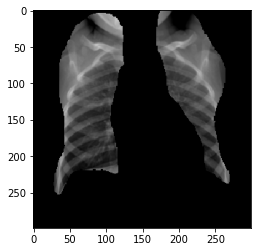

In [96]:
plt.imshow(img_data[100])

In [97]:
img_data.dtype

dtype('int32')

In [98]:
num_classes = 3
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples), dtype = 'int32')

In [99]:
labels[:91] = 0
labels[91:182] = 1
labels[182:] = 2

names = ['Covid-19', 'Normal', 'Pneumonia']

In [100]:
labels.shape

(279,)

In [101]:
Y = np_utils.to_categorical(labels, num_classes)

X_test,Y_test = shuffle(img_data,Y, random_state=2)

## Simple Model

In [47]:
Model_n = tf.keras.models.load_model("Xception.h5")

In [48]:
from tensorflow.keras.applications.xception import preprocess_input
X_test = preprocess_input(X_test)

In [49]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = Model_n.predict(X_test)
y_p = np.argmax(y_pred,axis=1)
y_true = np.argmax(Y_test,axis=1)
print('confusion matrix')
print(confusion_matrix(y_true,y_p))

confusion matrix
[[85  1  5]
 [ 0 81 10]
 [ 2 14 81]]


In [50]:
print('Classification report')
print(classification_report(y_true,y_p))

Classification report
              precision    recall  f1-score   support

           0       0.98      0.93      0.96        91
           1       0.84      0.89      0.87        91
           2       0.84      0.84      0.84        97

    accuracy                           0.89       279
   macro avg       0.89      0.89      0.89       279
weighted avg       0.89      0.89      0.89       279



ML Techniques

In [51]:
classifier = tf.keras.models.load_model("Xception.h5")

In [52]:
from tensorflow.keras.models import Model

op_layer = classifier.get_layer('fc3').output
Model_new = Model(inputs = classifier.input , outputs = op_layer)

In [53]:
x_test_new,y_test_new = shuffle(img_data,labels, random_state=2)

In [54]:
from tensorflow.keras.applications.xception import preprocess_input
x_test_new = preprocess_input(x_test_new)

In [55]:
test_new_x = Model_new.predict(x_test_new)

svm

In [56]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = svm.predict(test_new_x)
y_true = y_test_new
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[83  0  8]
 [ 0 78 13]
 [ 1  8 88]]
              precision    recall  f1-score   support

           0       0.99      0.91      0.95        91
           1       0.91      0.86      0.88        91
           2       0.81      0.91      0.85        97

    accuracy                           0.89       279
   macro avg       0.90      0.89      0.89       279
weighted avg       0.90      0.89      0.89       279



xg_boost

In [57]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = xb.predict(test_new_x)
y_true = y_test_new
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[83  1  7]
 [ 0 79 12]
 [ 1  8 88]]
              precision    recall  f1-score   support

           0       0.99      0.91      0.95        91
           1       0.90      0.87      0.88        91
           2       0.82      0.91      0.86        97

    accuracy                           0.90       279
   macro avg       0.90      0.90      0.90       279
weighted avg       0.90      0.90      0.90       279



random_forest

In [58]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = rf.predict(test_new_x)
y_true = y_test_new
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[83  1  7]
 [ 0 79 12]
 [ 1  8 88]]
              precision    recall  f1-score   support

           0       0.99      0.91      0.95        91
           1       0.90      0.87      0.88        91
           2       0.82      0.91      0.86        97

    accuracy                           0.90       279
   macro avg       0.90      0.90      0.90       279
weighted avg       0.90      0.90      0.90       279



## Feature Extraction

### SIFT

In [101]:
! pip install opencv-python==3.4.2.16
! pip install opencv-contrib-python==3.4.2.16

In [102]:
import cv2

In [103]:
sift = cv2.xfeatures2d.SIFT_create()
des_list = []

In [104]:
for i in tqdm(range(len(img_data))):
  img = img_data[i].copy()
  img = np.uint8(img)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  kpts, des = sift.detectAndCompute(img, None)
  des_list.append((i, des))

100%|██████████| 279/279 [00:08<00:00, 33.21it/s]


In [105]:
image = cv2.drawKeypoints(image=img, outImage=img, keypoints=kpts, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

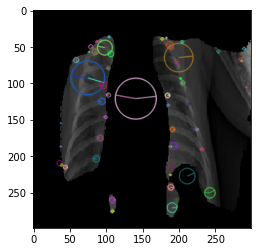

In [106]:
plt.imshow(image)
plt.show()

In [107]:
descriptors = des_list[0][1]
for img_no, descriptor in tqdm(des_list[:]):
  try:
    descriptors = np.vstack((descriptors, descriptor))
  except:
    continue

100%|██████████| 279/279 [00:01<00:00, 233.07it/s]


In [108]:
descriptors_float = descriptors.astype(float)

In [109]:
from scipy.cluster.vq import kmeans, vq
# we can change the value of k (no of clusters) to see the different accuracies
k = 128
voc, variance = kmeans(descriptors_float, k, 1)

In [110]:
im_features = np.zeros((len(img_data), k), "float32")
for i in tqdm(range(len(img_data))):
  try:
    words, distance = vq(des_list[i][1],voc)
    for w in words:
      im_features[i][w] += 1
  except:
    continue 

100%|██████████| 279/279 [00:00<00:00, 649.52it/s]


In [111]:
nbr_occurances = np.sum((im_features > 0) * 1, axis = 0)
idf = np.array(np.log((1.0*len(img_data) + 1) / (1.0*nbr_occurances + 1)), "float32")

In [112]:
from sklearn.preprocessing import StandardScaler
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)

In [113]:
im_features.shape

(279, 128)

In [114]:
im_features.dtype

dtype('float32')

In [115]:
Model_s = tf.keras.models.load_model("Xception.h5")

In [116]:
from tensorflow.keras.models import Model

op_layer = Model_s.get_layer('fc3').output
Model_C = Model(inputs = Model_s.input , outputs = op_layer)

In [117]:
from tensorflow.keras.applications.xception import preprocess_input
img_data = preprocess_input(img_data)

In [118]:
Pred_fc3 = Model_C.predict(img_data)

In [119]:
total_features = 384
total_dataset = 279

feature_data = np.zeros((total_dataset, total_features), dtype = 'float32')

for i in tqdm(range(len(feature_data))):
  cv_feature = im_features[i]
  model_feature = Pred_fc3[i]
  feature_data[i] = np.concatenate((cv_feature,model_feature))

100%|██████████| 279/279 [00:00<00:00, 176422.56it/s]


In [120]:
feature_data.shape

(279, 384)

In [121]:
num_classes = 3
num_of_samples = feature_data.shape[0]
labels = np.ones((num_of_samples), dtype = 'int32')

labels[:91] = 0
labels[91:182] = 1
labels[182:] = 2

names = ['Covid-19', 'Normal', 'Pneumonia']

In [122]:
Y = np_utils.to_categorical(labels, num_classes)

X_test_SIFT,Y_test_SIFT = shuffle(feature_data,Y, random_state=2)

In [123]:
Model_n = tf.keras.models.load_model("Xception_combined_SIFT.h5")

In [124]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = Model_n.predict(X_test_SIFT)
y_p = np.argmax(y_pred,axis=1)
y_true = np.argmax(Y_test_SIFT,axis=1)
print('confusion matrix')
print(confusion_matrix(y_true,y_p))

confusion matrix
[[78  5  8]
 [ 1 74 16]
 [ 1  8 88]]


In [125]:
print('Classification report')
print(classification_report(y_true,y_p))

Classification report
              precision    recall  f1-score   support

           0       0.97      0.86      0.91        91
           1       0.85      0.81      0.83        91
           2       0.79      0.91      0.84        97

    accuracy                           0.86       279
   macro avg       0.87      0.86      0.86       279
weighted avg       0.87      0.86      0.86       279



#### ML Techniques

In [126]:
from tensorflow.keras.models import Model

op_layer = Model_n.get_layer('dense_6').output
Model_csn = Model(inputs = Model_n.input , outputs = op_layer)

In [127]:
x_new_test,y_new_test = shuffle(feature_data,labels, random_state=2)

In [128]:
new_test_x = Model_csn.predict(x_new_test)

In [129]:
from sklearn.metrics import confusion_matrix, classification_report

svm

In [130]:
y_pred = svm.predict(new_test_x)
y_true = y_new_test
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[76  9  6]
 [ 0 80 11]
 [ 1 14 82]]
              precision    recall  f1-score   support

           0       0.99      0.84      0.90        91
           1       0.78      0.88      0.82        91
           2       0.83      0.85      0.84        97

    accuracy                           0.85       279
   macro avg       0.86      0.85      0.86       279
weighted avg       0.86      0.85      0.86       279



xg_boost

In [131]:
y_pred = xb.predict(new_test_x)
y_true = y_new_test
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[80  3  8]
 [ 0 74 17]
 [ 1 10 86]]
              precision    recall  f1-score   support

           0       0.99      0.88      0.93        91
           1       0.85      0.81      0.83        91
           2       0.77      0.89      0.83        97

    accuracy                           0.86       279
   macro avg       0.87      0.86      0.86       279
weighted avg       0.87      0.86      0.86       279



random forest

In [132]:
y_pred = rf.predict(new_test_x)
y_true = y_new_test
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[78  5  8]
 [ 0 75 16]
 [ 1 10 86]]
              precision    recall  f1-score   support

           0       0.99      0.86      0.92        91
           1       0.83      0.82      0.83        91
           2       0.78      0.89      0.83        97

    accuracy                           0.86       279
   macro avg       0.87      0.86      0.86       279
weighted avg       0.87      0.86      0.86       279



### BRISK

In [102]:
import cv2

In [103]:
brisk = cv2.BRISK_create(50)
des_list = []

In [104]:
for i in tqdm(range(len(img_data))):
  img = img_data[i].copy()
  img = np.uint8(img)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  kpts, des = brisk.detectAndCompute(img, None)
  des_list.append((i, des))

100%|██████████| 279/279 [00:01<00:00, 167.53it/s]


In [105]:
image = cv2.drawKeypoints(image=img, outImage=img, keypoints=kpts, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

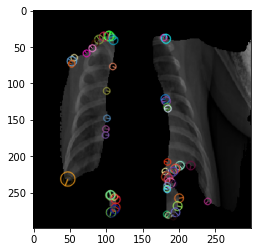

In [106]:
plt.imshow(image)
plt.show()

In [107]:
descriptors = des_list[0][1]
for img_no, descriptor in tqdm(des_list[:]):
  try:
    descriptors = np.vstack((descriptors, descriptor))
  except:
    continue

100%|██████████| 279/279 [00:00<00:00, 3520.30it/s]


In [108]:
descriptors_float = descriptors.astype(float)

In [109]:
from scipy.cluster.vq import kmeans, vq
# we can change the value of k (no of clusters) to see the different accuracies
k = 128
voc, variance = kmeans(descriptors_float, k, 1)

In [110]:
im_features = np.zeros((len(img_data), k), "float32")
for i in tqdm(range(len(img_data))):
  try:
    words, distance = vq(des_list[i][1],voc)
    for w in words:
      im_features[i][w] += 1
  except:
    continue 

100%|██████████| 279/279 [00:00<00:00, 869.86it/s]


In [111]:
nbr_occurances = np.sum((im_features > 0) * 1, axis = 0)
idf = np.array(np.log((1.0*len(img_data) + 1) / (1.0*nbr_occurances + 1)), "float32")

In [112]:
from sklearn.preprocessing import StandardScaler
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)

In [113]:
im_features.shape

(279, 128)

In [114]:
im_features.dtype

dtype('float32')

In [115]:
Model_s = tf.keras.models.load_model("Xception.h5")

In [116]:
from tensorflow.keras.models import Model

op_layer = Model_s.get_layer('fc3').output
Model_C = Model(inputs = Model_s.input , outputs = op_layer)

In [117]:
from tensorflow.keras.applications.xception import preprocess_input
img_data = preprocess_input(img_data)

In [118]:
Pred_fc3 = Model_C.predict(img_data)

In [119]:
total_features = 384
total_dataset = 279

feature_data = np.zeros((total_dataset, total_features), dtype = 'float32')

for i in tqdm(range(len(feature_data))):
  cv_feature = im_features[i]
  model_feature = Pred_fc3[i]
  feature_data[i] = np.concatenate((cv_feature,model_feature))

100%|██████████| 279/279 [00:00<00:00, 108032.76it/s]


In [120]:
feature_data.shape

(279, 384)

In [121]:
num_classes = 3
num_of_samples = feature_data.shape[0]
labels = np.ones((num_of_samples), dtype = 'int32')

labels[:91] = 0
labels[91:182] = 1
labels[182:] = 2

names = ['Covid-19', 'Normal', 'Pneumonia']

In [122]:
Y = np_utils.to_categorical(labels, num_classes)

X_test_SIFT,Y_test_SIFT = shuffle(feature_data,Y, random_state=2)

In [123]:
Model_n = tf.keras.models.load_model("Xception_combined_BRISK.h5")

In [124]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = Model_n.predict(X_test_SIFT)
y_p = np.argmax(y_pred,axis=1)
y_true = np.argmax(Y_test_SIFT,axis=1)
print('confusion matrix')
print(confusion_matrix(y_true,y_p))

confusion matrix
[[81  0 10]
 [ 0 76 15]
 [ 1  6 90]]


In [125]:
print('Classification report')
print(classification_report(y_true,y_p))

Classification report
              precision    recall  f1-score   support

           0       0.99      0.89      0.94        91
           1       0.93      0.84      0.88        91
           2       0.78      0.93      0.85        97

    accuracy                           0.89       279
   macro avg       0.90      0.88      0.89       279
weighted avg       0.90      0.89      0.89       279



#### ML Techniques

In [126]:
from tensorflow.keras.models import Model

op_layer = Model_n.get_layer('dense_6').output
Model_csn = Model(inputs = Model_n.input , outputs = op_layer)

In [127]:
x_new_test,y_new_test = shuffle(feature_data,labels, random_state=2)

In [128]:
new_test_x = Model_csn.predict(x_new_test)

In [129]:
from sklearn.metrics import confusion_matrix, classification_report

svm

In [130]:
y_pred = svm.predict(new_test_x)
y_true = y_new_test
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[80  4  7]
 [ 0 79 12]
 [ 1  8 88]]
              precision    recall  f1-score   support

           0       0.99      0.88      0.93        91
           1       0.87      0.87      0.87        91
           2       0.82      0.91      0.86        97

    accuracy                           0.89       279
   macro avg       0.89      0.88      0.89       279
weighted avg       0.89      0.89      0.89       279



xg_boost

In [131]:
y_pred = xb.predict(new_test_x)
y_true = y_new_test
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[80  2  9]
 [ 0 76 15]
 [ 1  8 88]]
              precision    recall  f1-score   support

           0       0.99      0.88      0.93        91
           1       0.88      0.84      0.86        91
           2       0.79      0.91      0.84        97

    accuracy                           0.87       279
   macro avg       0.89      0.87      0.88       279
weighted avg       0.88      0.87      0.88       279



random forest

In [132]:
y_pred = rf.predict(new_test_x)
y_true = y_new_test
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[81  1  9]
 [ 0 76 15]
 [ 1  7 89]]
              precision    recall  f1-score   support

           0       0.99      0.89      0.94        91
           1       0.90      0.84      0.87        91
           2       0.79      0.92      0.85        97

    accuracy                           0.88       279
   macro avg       0.89      0.88      0.88       279
weighted avg       0.89      0.88      0.88       279

